In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statistics import mode
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import re
import math
from google.colab import files
from IPython.display import display
from matplotlib import rcParams
import ipywidgets as widgets

# Data loading and clearning

In [9]:
#Load the dataset to the data DataFrame.


filename = 'The-Big-List.csv'
data = pd.read_csv(filename,sep='\t')

In [10]:
display(data)

,Review #,Brand,Variety,Style,Country,Stars,T
0,3950,Nissin,Mocchi Cchi Hello Kitty Yakisoba,Cup,Japan,3.75,NaN
1,3949,Liitle Couples,Fish Head Casserole,Pack,Taiwan,5,NaN
2,3948,Yamasa,Artisanal Ramen Broth - Miso / Jongga Ramen Sari,Pack,South Korea,3.5,NaN
3,3947,Nissin,Cup Noodles Roasted Duck w/Sweet Onion Soup,Cup,Germany,3.25,NaN
4,3946,Nissin,Donbei Simple Taste Somen,Bowl,Japan,0,NaN
...,...,...,...,...,...,...,...
3945,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.5,NaN
3946,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,NaN
3947,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,NaN
3948,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,NaN


In [11]:
#Here we perform initial data clearning

data['Brand']=data['Brand'].str.lower()
data['Variety']=data['Variety'].str.lower()
data['Style']=data['Style'].str.lower()
data['Country']=data['Country'].str.lower()
data.drop(['T','Review #'], inplace=True, axis=1)

#Some of the ratings are written as 3/5 or 5/5. In those cases we take the first number
stars=list(data['Stars'])
stars=[s.split('/')[0] for s in stars ]
data['Stars']=stars
data['Stars']=pd.to_numeric(data['Stars'],errors='coerce')

#For some of entries ratings are not available. I left them completely out of the analysis.
print('data shape before removing NaNs', data.shape)
data.dropna(inplace=True)
print('data shape after removing NaNs', data.shape)

#Change all string columns to categorical
data.iloc[:,0:4]=data.iloc[:,0:4].astype('category')
print(f'\n\ndata types\n{data.dtypes}')

data shape before removing NaNs (3950, 5)
data shape after removing NaNs (3943, 5)


data types
Brand       object
Variety     object
Style       object
Country     object
Stars      float64
dtype: object


In [12]:
#Here we correct some of the countries names

data.replace('souh korea', 'south korea', inplace=True)
data.replace('russian federation',  'russia', inplace=True)
data.replace('usa','united states', inplace=True)
data.replace('uk', 'united kingdom', inplace=True)
data.replace('phlippines',  'philippines', inplace=True)

#Set the correct index of the data, so that it is continuos
data.set_index(np.array(range(len(data))), inplace=True)

In [13]:
display(data)

,Brand,Variety,Style,Country,Stars
0,nissin,mocchi cchi hello kitty yakisoba,cup,japan,3.75
1,liitle couples,fish head casserole,pack,taiwan,5.00
2,yamasa,artisanal ramen broth - miso / jongga ramen sari,pack,south korea,3.50
3,nissin,cup noodles roasted duck w/sweet onion soup,cup,germany,3.25
4,nissin,donbei simple taste somen,bowl,japan,0.00
...,...,...,...,...,...
3938,vifon,"hu tiu nam vang [""phnom penh"" style] asian sty...",bowl,vietnam,3.50
3939,wai wai,oriental style instant noodles,pack,thailand,1.00
3940,wai wai,tom yum shrimp,pack,thailand,2.00
3941,wai wai,tom yum chili flavor,pack,thailand,2.00


# Plotting the data

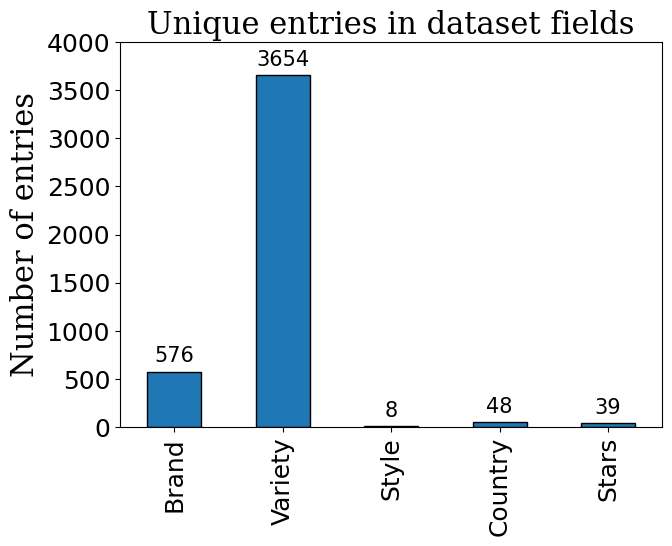

In [14]:
toplot={}
for col in data.columns:
  toplot[col]=len(data.groupby(col).count())
toplot=pd.DataFrame.from_dict(toplot,orient='index')

fig,ax=plt.subplots(figsize=(7,5))
toplot.plot(ax=ax,kind='bar', fontsize=12, legend=False, edgecolor='black')
ax.set_title('Unique entries in dataset fields', fontsize=22, fontname="serif")
ax.set_ylabel('Number of entries', fontsize=22, fontname="serif")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,4000)
for p in ax.patches:
  height=p.get_height()
  ax.annotate(f'{height}',
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 4),  # 4 points vertical offset.
            textcoords='offset points',
            ha='center', va='bottom',fontsize = 15)
plt.show()
# plt.savefig('fig3.png')
# files.download("fig3.png")

Columns 'Brand' and 'Variety' have too many entries to plot directly before text preprocessing, so we will plot here only columns 'Style', 'Country', and 'Stars'

## Column 'Stars'

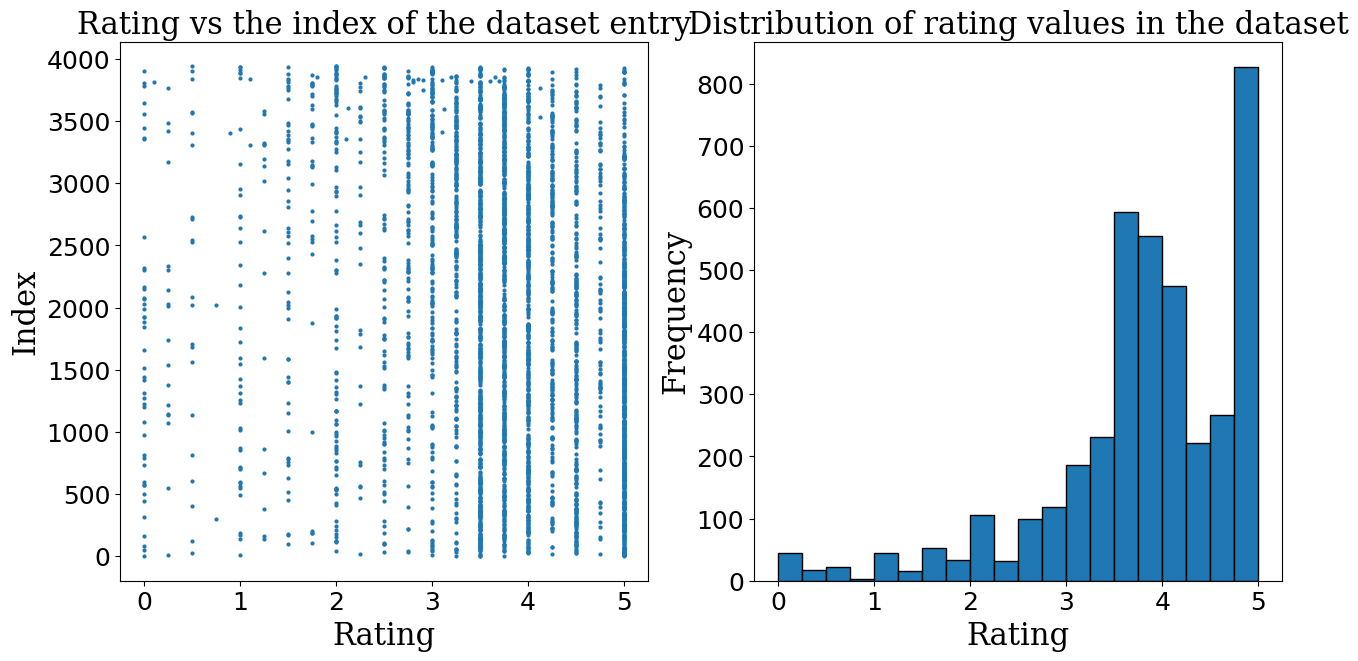

In [15]:
#Here we plot distribution of the rating ('Stars')
#Original rating is distributed between 0 and 5.
fig,ax=plt.subplots(1,2,figsize=(15,7))

toplotx=data['Stars']
toploty=pd.DataFrame(data.index)
toplot=pd.concat([toplotx,toploty],axis=1)
toplot.columns=['rating', 'index']
toplot.plot.scatter(ax=ax[0],x='rating',y='index', s = 4)
ax[0].set_title('Rating vs the index of the dataset entry', fontsize=22, fontname="serif")
ax[0].set_xlabel('Rating', fontsize=22, fontname="serif")
ax[0].set_ylabel('Index', fontsize=22, fontname="serif")
ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)

toplot=data['Stars']
toplot.plot.hist(ax=ax[1],bins=20, fontsize=12, edgecolor='black')
ax[1].set_title('Distribution of rating values in the dataset', fontsize=22, fontname="serif")
ax[1].set_xlabel('Rating', fontsize=22, fontname="serif")
ax[1].set_ylabel('Frequency', fontsize=22, fontname="serif")
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)


plt.show()
# plt.savefig('fig2.png')
# files.download("fig2.png")

## Column 'Country'

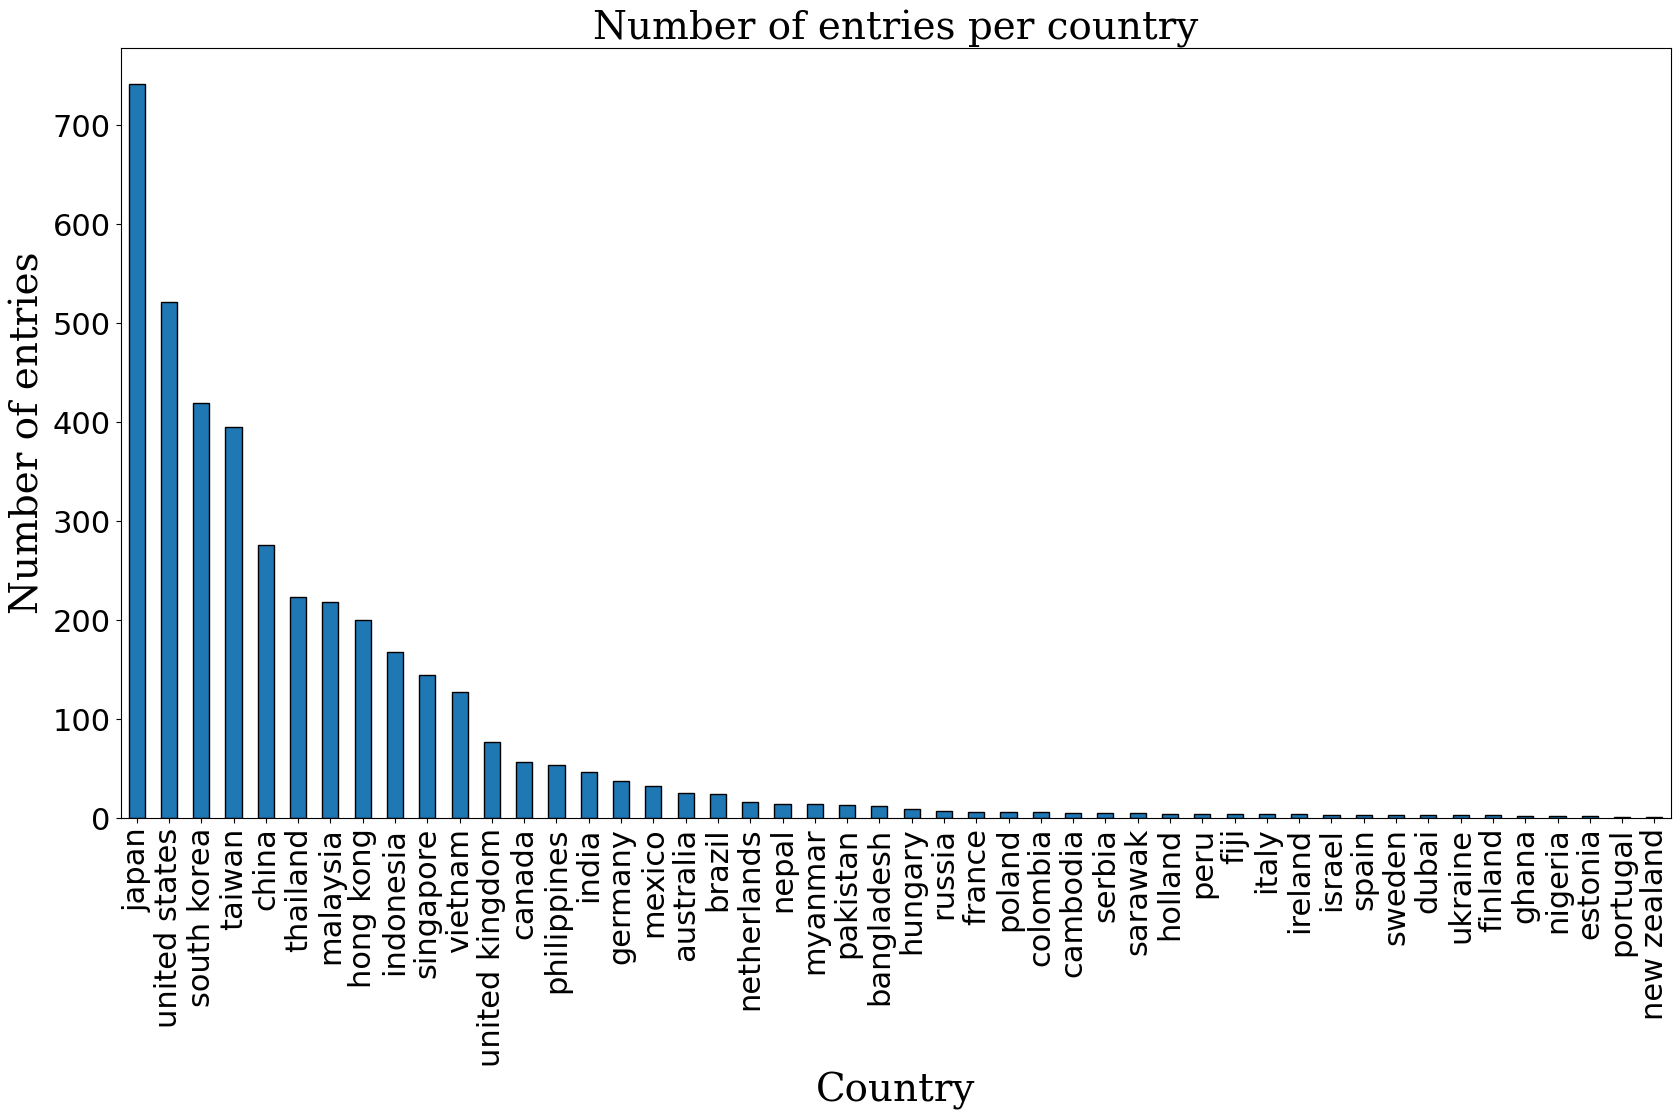

In [16]:
toplot=data.groupby('Country')['Stars'].count()
toplot.sort_values(inplace=True, ascending=False)
fig,ax=plt.subplots(figsize=(20,10))
toplot.plot(ax=ax,kind='bar', fontsize=12, edgecolor='black')
ax.set_title('Number of entries per country', fontsize=28, fontname="serif")
ax.set_xlabel('Country', fontsize=28, fontname="serif")
ax.set_ylabel('Number of entries', fontsize=28, fontname="serif")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()
# plt.savefig('fig4.png')
# files.download("fig4.png")

In [17]:
# Here we find countries that have less than 3 entries in the database and remove them

country_list=data.groupby('Country')['Stars'].count()
country_list.sort_values(inplace=True, ascending=False)
for cntry in list(country_list[country_list<3].index):
  data = data.drop(data.index[data['Country'] == cntry])
print(data['Country'].value_counts())

Country
japan             741
united states     521
south korea       419
taiwan            395
china             275
thailand          223
malaysia          218
hong kong         200
indonesia         167
singapore         144
vietnam           127
united kingdom     76
canada             56
philippines        53
india              46
germany            37
mexico             32
australia          25
brazil             24
netherlands        16
myanmar            14
nepal              14
pakistan           13
bangladesh         12
hungary             9
russia              7
france              6
poland              6
colombia            6
sarawak             5
cambodia            5
serbia              5
peru                4
italy               4
fiji                4
holland             4
ireland             4
sweden              3
spain               3
finland             3
ukraine             3
israel              3
dubai               3
Name: count, dtype: int64


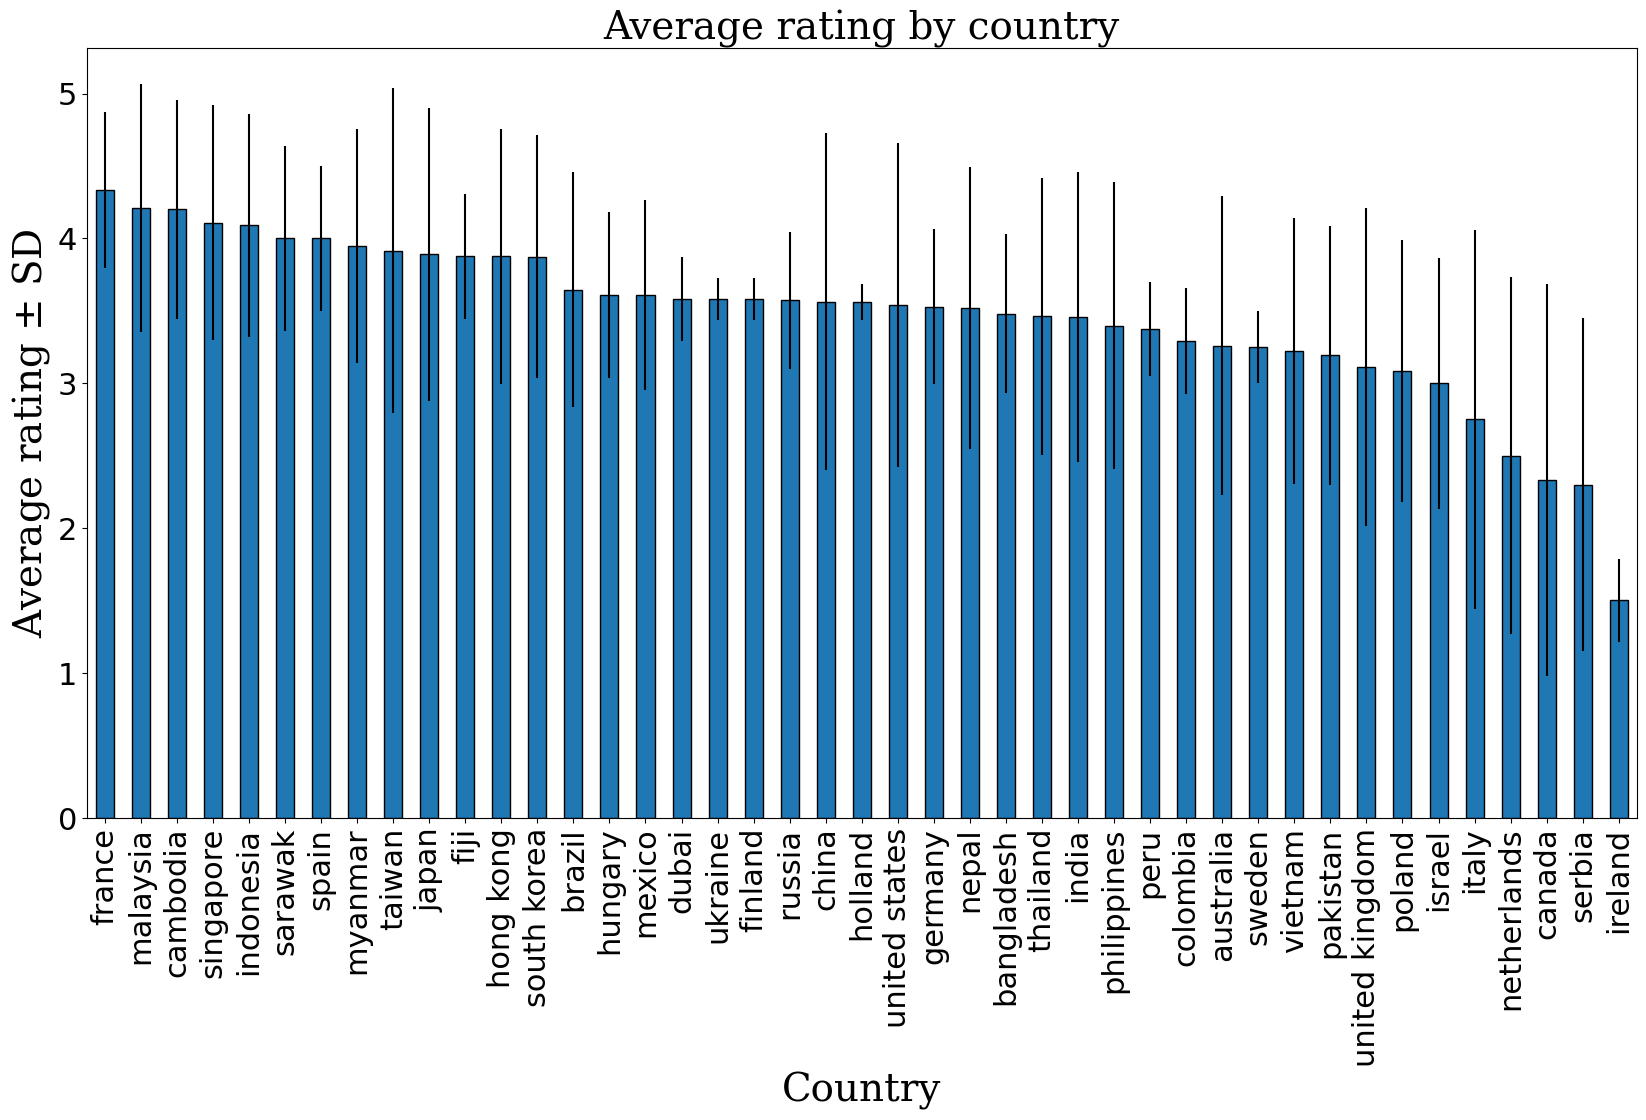

In [18]:
toplot = data.groupby('Country')['Stars'].mean().sort_values(ascending=False)
fig,ax = plt.subplots(figsize=(20,10))
toplot.plot(ax=ax,kind='bar',yerr=data.groupby('Country')['Stars'].std(),legend=False, edgecolor='black')
ax.set_title('Average rating by country', fontsize=28, fontname="serif")
ax.set_xlabel('Country', fontsize=28, fontname="serif")
ax.set_ylabel('Average rating $\pm$ SD', fontsize=28, fontname="serif")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()
# plt.savefig('fig5.png')
# files.download("fig5.png")

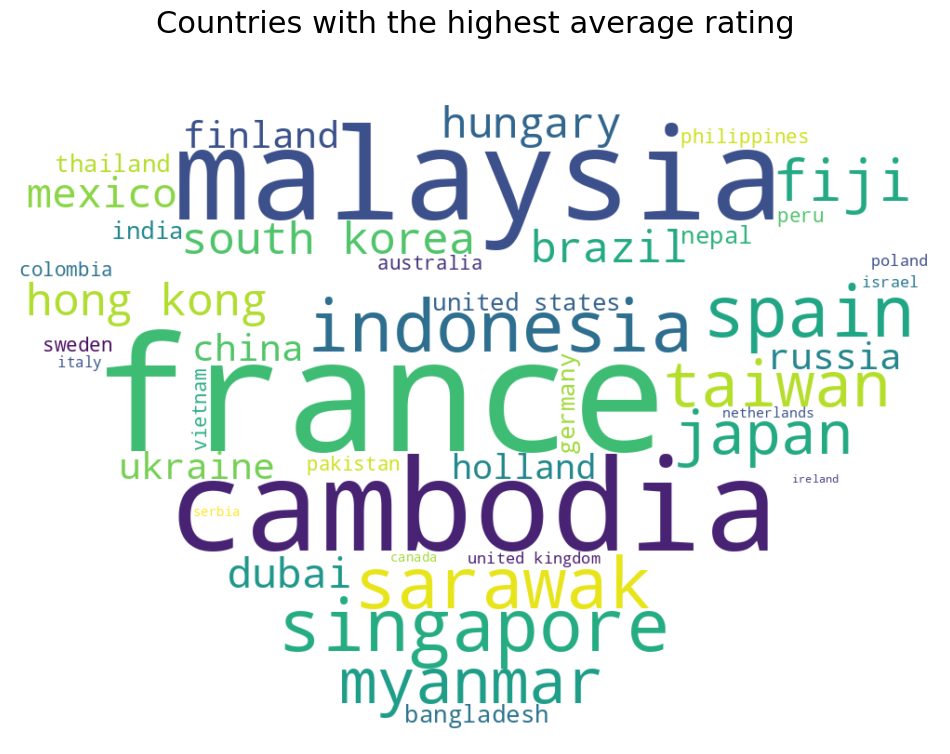

In [19]:
# Word Cloud for the average rating per country
countr=data.groupby('Country')['Stars'].mean().sort_values(ascending=False)
countr=countr.to_dict()
custom_mask = np.array(Image.open("bowlmask.jpg"))
wordcloud = WordCloud(max_font_size=None, mask=custom_mask, background_color='white', width=1200, height=1000, normalize_plurals=False)
wordcloud.generate_from_frequencies(countr)

fig,ax=plt.subplots(figsize=(12,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title('Countries with the highest average rating', fontsize=22, y=1.08)
plt.axis("off")
plt.show()

# wordcloud.to_file('country-by-rating.png')
# files.download("country-by-rating.png")

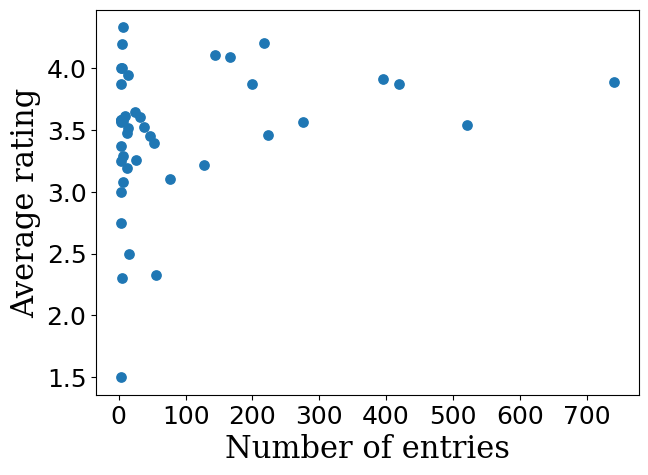

In [20]:
toplotx=data.groupby('Country')['Stars'].count()

toploty=data.groupby('Country')['Stars'].mean()

toplot=pd.concat([toplotx,toploty],axis=1)
toplot.columns=['number of entries', 'average rating']

fig,ax=plt.subplots(figsize=(7,5))
toplot.plot.scatter(ax=ax,x='number of entries',y='average rating', s = 45)
ax.set_xlabel('Number of entries', fontsize=22, fontname="serif")
ax.set_ylabel('Average rating', fontsize=22, fontname="serif")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()
# plt.savefig('fig6.png')
# files.download("fig6.png")

## Column 'Style'

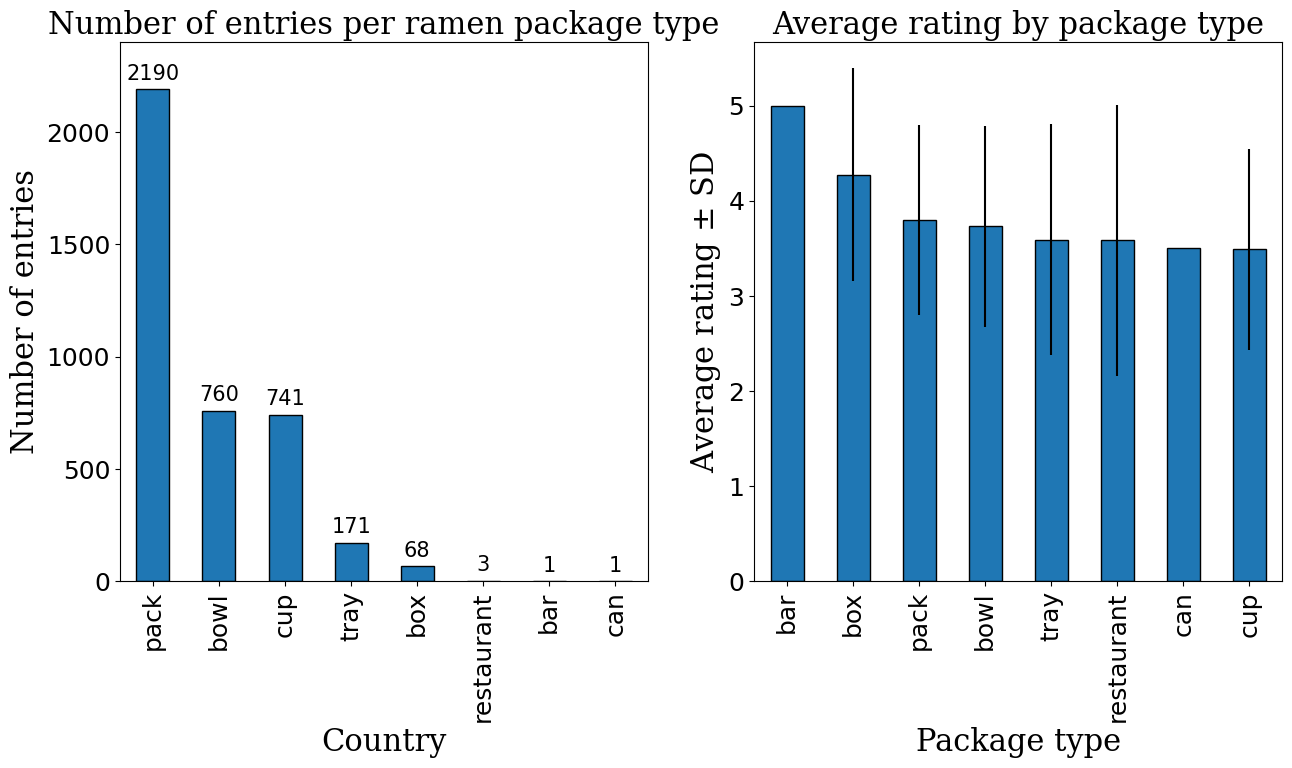

In [21]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

toplot=data.groupby('Style')['Stars'].count()
toplot.sort_values(inplace=True, ascending=False)

toplot.plot(ax=ax[0],kind='bar', fontsize=12, edgecolor = 'black')
ax[0].set_title('Number of entries per ramen package type', fontsize=22, fontname="serif")
ax[0].set_xlabel('Country', fontsize=22, fontname="serif")
ax[0].set_ylabel('Number of entries', fontsize=22, fontname="serif")
ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)
ax[0].set_ylim(0,2400)
for p in ax[0].patches:
  height=p.get_height()
  ax[0].annotate(f'{height}',
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 4),  # 4 points vertical offset.
            textcoords='offset points',
            ha='center', va='bottom',fontsize = 15)

toplot=data.groupby('Style')['Stars'].mean().sort_values(ascending=False)
toplot.plot(ax=ax[1],kind='bar',yerr=data.groupby('Style')['Stars'].std(),legend=False, edgecolor = 'black')
ax[1].set_title('Average rating by package type', fontsize=22, fontname="serif")
ax[1].set_xlabel('Package type', fontsize=22, fontname="serif")
ax[1].set_ylabel('Average rating $\pm$ SD', fontsize=22, fontname="serif")
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)



plt.show()
# plt.savefig('fig7.png')
# files.download("fig7.png")

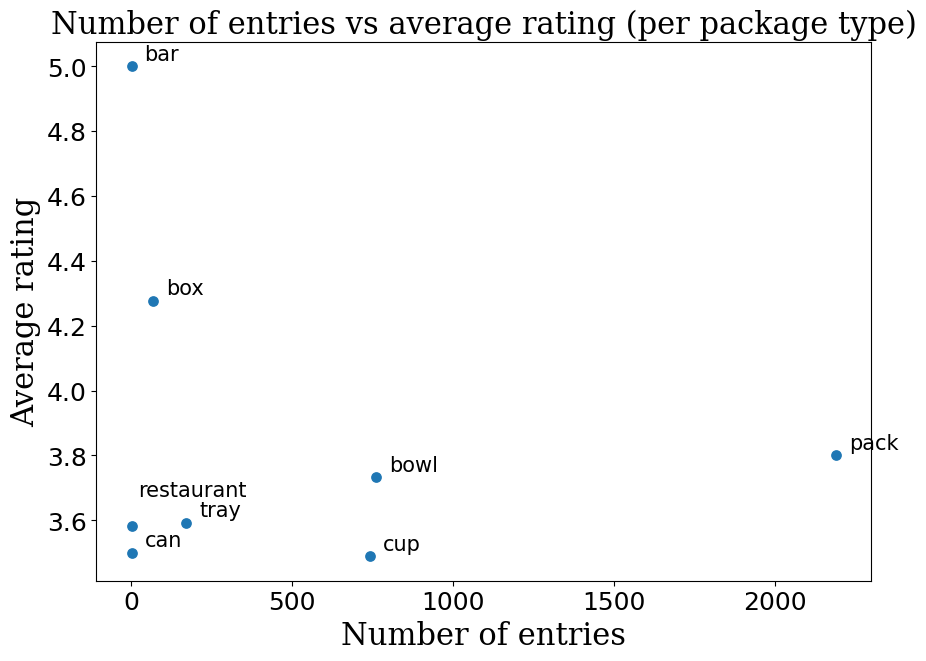

In [22]:
toplotx=data.groupby('Style')['Stars'].count()

toploty=data.groupby('Style')['Stars'].mean()

toplot=pd.concat([toplotx,toploty],axis=1)
toplot.columns=['number of entries', 'average rating']

toplotx = data.groupby('Style', as_index = False)['Stars'].count()
toploty = data.groupby('Style', as_index = False)['Stars'].mean()

fig,ax=plt.subplots(figsize=(10,7))
toplot.plot.scatter(ax=ax,x='number of entries',y='average rating', s = 45)
ax.set_title('Number of entries vs average rating (per package type)', fontsize=22, fontname="serif")
ax.set_xlabel('Number of entries', fontsize=22, fontname="serif")
ax.set_ylabel('Average rating', fontsize=22, fontname="serif")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for i in range(8):
  if i == 6:
    ax.annotate(str(toplot.index[i]), (toplotx['Stars'].iloc[i]+20, toploty['Stars'].iloc[i]+0.09), fontsize = 15)
  else:
    ax.annotate(str(toplot.index[i]), (toplotx['Stars'].iloc[i]+40, toploty['Stars'].iloc[i]+0.02), fontsize = 15)

plt.show()
# plt.savefig('fig9.png')
# files.download("fig9.png")

In [23]:
# Here we find styles that have less then 3 entries in the database and remove them

style_list=data.groupby('Style')['Stars'].count()
style_list.sort_values(inplace=True, ascending=False)
for style in list(style_list[style_list<3].index):
  data = data.drop(data.index[data['Style'] == style])
print(data['Style'].value_counts())

Style
pack          2190
bowl           760
cup            741
tray           171
box             68
restaurant       3
Name: count, dtype: int64


## Column 'Brand'

In [24]:
# Here we find brands that have less then 3 entries in the database remove them

brand_list=data.groupby('Brand')['Stars'].count()
brand_list.sort_values(inplace=True, ascending=False)
for brand in list(brand_list[brand_list<3].index):
  data = data.drop(data.index[data['Brand'] == brand])

print(data['Brand'].value_counts())

Brand
nissin          501
maruchan        139
nongshim        125
myojo           121
mama            104
               ... 
fashion food      3
peyoung           3
shun savory       3
e-zee             3
jongga            3
Name: count, Length: 259, dtype: int64


In [25]:
#We correct index of the data so that it is continuos
data.set_index(np.array(range(len(data))), inplace=True)

# Pre-processing the 'Variety' field  of the dataset

In [26]:
#here we pre-process the 'Variety' field in order to extract individual words
def split_variety(variety_string):
  out=re.split(' |/|-|&|\)|\(|\.|\[|\]|"', variety_string)
  out=[o for o in out if len(o)>1]
  return out
data['Taste']=data.apply(lambda row : split_variety(row.Variety), axis=1)

In [27]:
# More of pre-processing to correct for misspelling in the words related to tastes
correct={'chilli':'chili', 'yam':'yum', 'kari':'curry', 'goreng':'fried', 'carne':'beef', 'ayam':'chicken', 'gallina':'chicken', 'pollo':'chicken'}
new_taste=[]
for line in data['Taste']:
  for i, word in enumerate(line):
    if word in correct:
      line[i]=correct[word]
  new_taste.append(line)
data['Taste']=new_taste

In [28]:
#Here we create a WordStat dataframe to see the frequency of individual words and the rating associated with them
WordCount={}
WordRating={}
for i in range(len(data)):
  s=set(data['Taste'][i])
  for word in s:
    if word not in WordCount:
      WordCount[word]=1
      WordRating[word]=data['Stars'][i]
    else:
      WordCount[word]+=1
      WordRating[word]+=data['Stars'][i]
for word in WordCount:
  WordRating[word]=WordRating[word]/WordCount[word]

WordStat=pd.DataFrame(WordCount.items())
WordStat.columns=['Words', 'Counts']
WordStat['Rating']=WordRating.values()
WordStat.sort_values('Counts', ascending=False, inplace=True, ignore_index=True)

In [29]:
#Here we create a dictionary of a 100 most frequent terms (in the 'Variety' field) and their frequency (freq)
#remove those that do not relate to the taste discription (list eliminate) and create a list flavour that contains 54 tastes

freq = dict(zip(WordStat['Words'][:100], WordStat['Counts'][:100]))
eliminate = ['noodles', 'noodle', 'white', 'mian', 'red', 'authentic', 'ramen', 'instant', 'flavor', 'flavour', 'soup', 'cup', 'with', 'sauce', 'bowl', 'artificial', 'japanese', 'ramyun', 'rasa', 'sabor', 'laksa', 'thai', 'taste', 'original', 'super', 'new', 'king', 'kung', 'premium', 'dry', 'sichuan', 'men', 'dried', 'top', 'of', 'fu', 'snack', 'korean', 'chinese', 'mi', 'udon', 'oriental', 'demae', 'penang', 'vermicelli','style', 'yakisoba', 'black', 'big']
for i in eliminate:
  del freq[i]

flavour = [taste for taste in freq]

In [30]:
#Here we create a dictionary of a 100 most frequent terms and their rating (rtgn) and remove those that do not relate to the taste discription (list eliminate)

rtgn = dict(zip(WordStat['Words'][:100], WordStat['Rating'][:100]))

eliminate = ['noodles', 'noodle', 'white', 'mian', 'red', 'authentic', 'ramen', 'instant', 'flavor', 'flavour', 'soup', 'cup', 'with', 'sauce', 'bowl', 'artificial', 'japanese', 'ramyun', 'rasa', 'sabor', 'laksa', 'thai', 'taste', 'original', 'super', 'new', 'king', 'kung', 'premium', 'dry', 'sichuan', 'men', 'dried', 'top', 'of', 'fu', 'snack', 'korean', 'chinese', 'mi', 'udon', 'oriental', 'demae', 'penang', 'vermicelli','style', 'yakisoba', 'black', 'big']
for i in eliminate:
  del rtgn[i]

In [31]:
# Here we create a copy of the dataset (data_all), then remove all entries that do not have taste terms in the Variety field and store them in a new dataste (data_removed)
# In this way the data now contains only entries that include one or more taste terms in the 'Variety' field
ind=[]
rem=[]
for i, line in enumerate(data['Taste']):
  found=False
  for word in line:
    if word in flavour:
      found=True
  if found:
    ind.append(i)
  else:
    rem.append(i)
data_all=data.copy()
data_removed=data.iloc[rem,:]
data_removed.reset_index(inplace=True)
data=data.iloc[ind,:]
data.reset_index(inplace=True)
print(f'original dataset size: {len(data_all)}')
print(f'dataset size with taste terms: {len(data)}')
print(f'size of the deleted dataset: {len(data_removed)}')

original dataset size: 3526
dataset size with taste terms: 2716
size of the deleted dataset: 810


# Plotting tastes

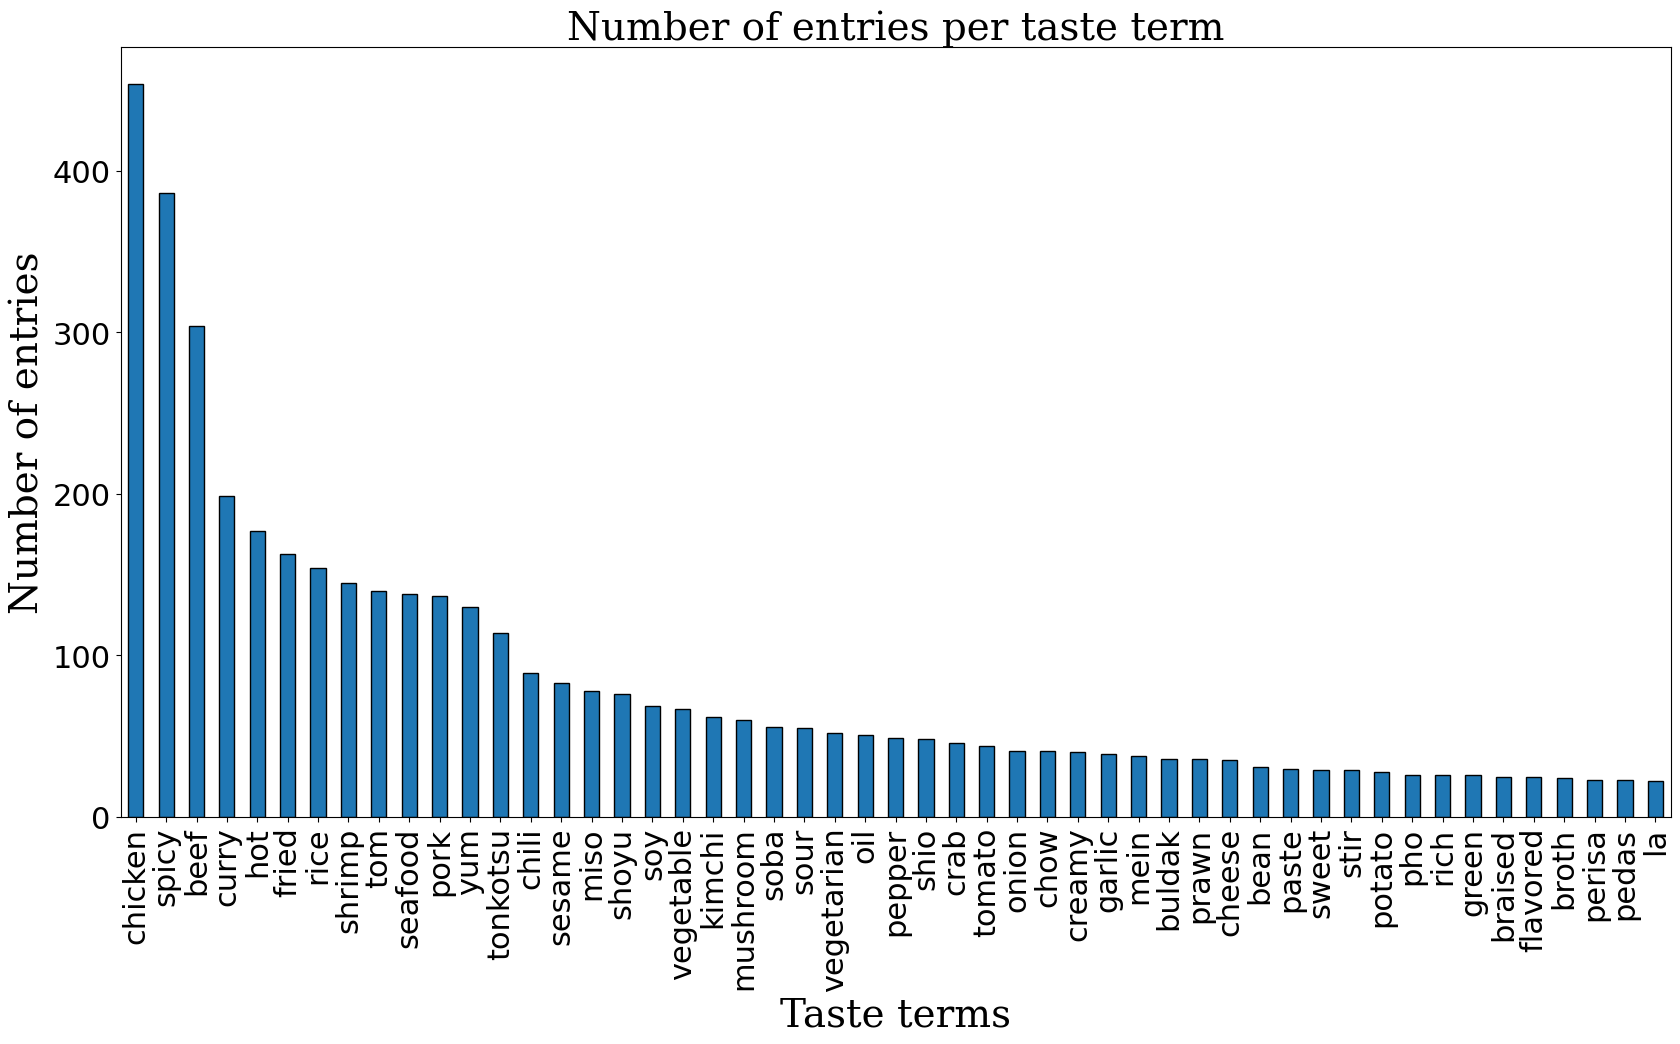

In [32]:
toplot=pd.DataFrame.from_dict(freq,orient='index')
toplot.columns=['freq']
toplot.sort_values('freq',inplace=True, ascending=False)
fig,ax=plt.subplots(figsize=(20,10))
toplot.plot(ax=ax,kind='bar', fontsize=12, edgecolor='black', legend=False)
ax.set_title('Number of entries per taste term', fontsize=28, fontname="serif")
ax.set_xlabel('Taste terms', fontsize=28, fontname="serif")
ax.set_ylabel('Number of entries', fontsize=28, fontname="serif")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()
# plt.savefig('fig9.png')
# files.download("fig9.png")

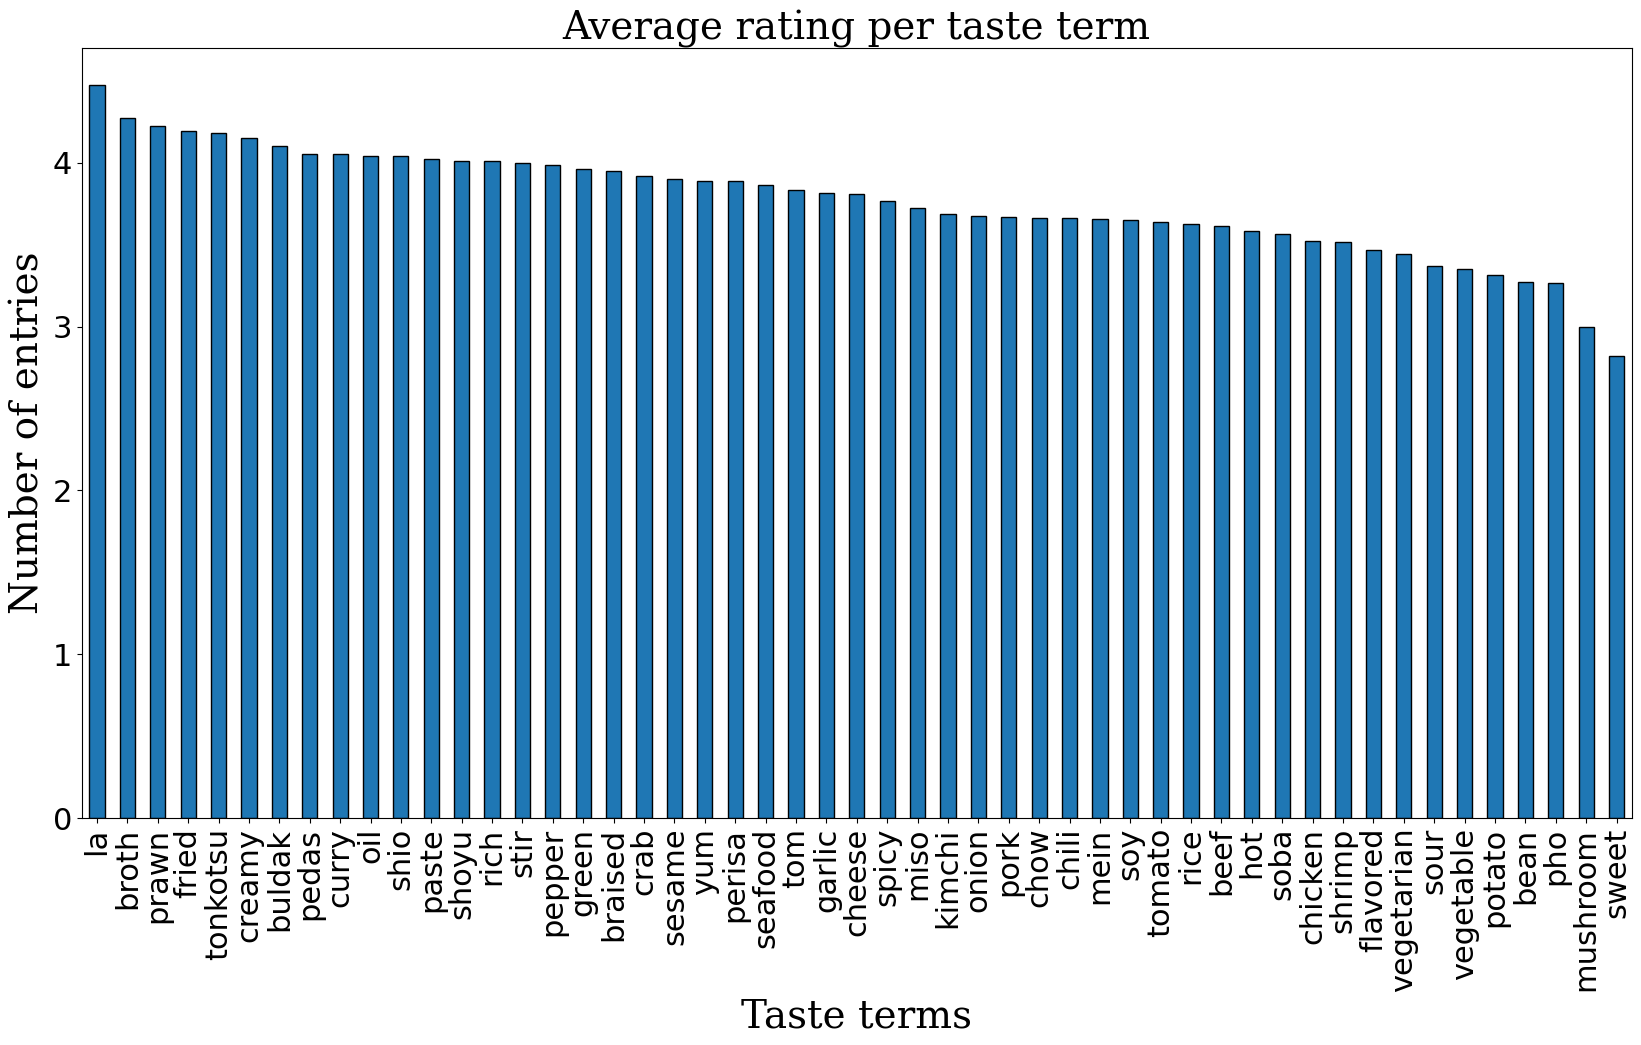

In [33]:
toplot=pd.DataFrame.from_dict(rtgn,orient='index')
toplot.columns=['rating']
toplot.sort_values('rating',inplace=True, ascending=False)
fig,ax=plt.subplots(figsize=(20,10))
toplot.plot(ax=ax,kind='bar', fontsize=12, edgecolor='black', legend=False)
ax.set_title('Average rating per taste term', fontsize=28, fontname="serif")
ax.set_xlabel('Taste terms', fontsize=28, fontname="serif")
ax.set_ylabel('Number of entries', fontsize=28, fontname="serif")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()
# plt.savefig('fig10.png')
# files.download("fig10.png")

## Word Cloud for the most frequent tastes and for the tastes with the highest average rating

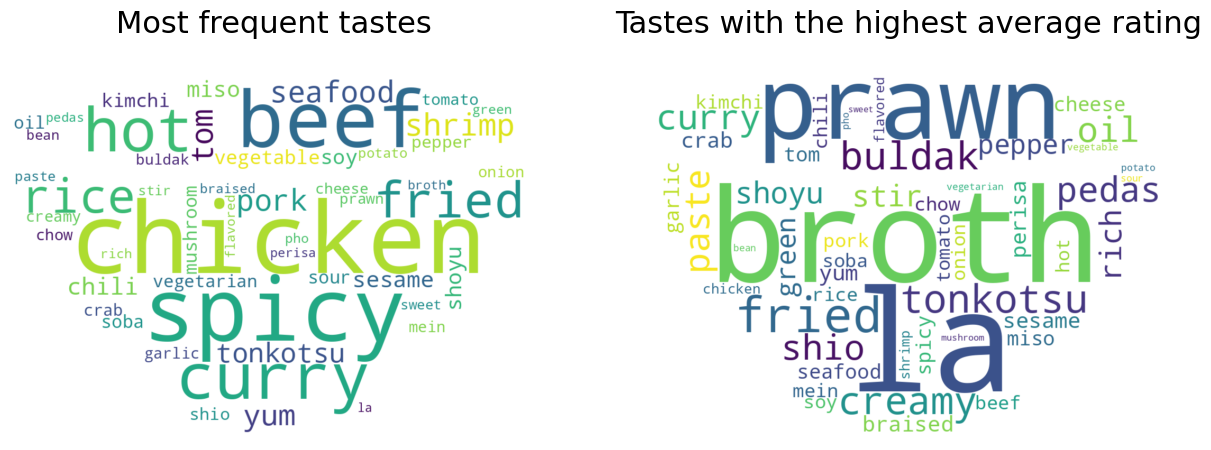

In [34]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

bowlmask = np.array(Image.open("bowlmask.jpg"))

# Word Cloud for the most frequent tastes
wordcloud = WordCloud(max_font_size=None, mask=bowlmask, background_color='white', width=1200, height=1000, normalize_plurals=False)
wordcloud.generate_from_frequencies(freq)

ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].set_title('Most frequent tastes', fontsize=22, y=1.08)
ax[0].axis("off")

# Word Cloud for the tastes with the highest rating
wordcloud = WordCloud(max_font_size=None, mask=bowlmask, background_color='white', width=1200, height=1000, normalize_plurals=False)
wordcloud.generate_from_frequencies(rtgn)

ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].set_title('Tastes with the highest average rating', fontsize=22, y=1.08)
ax[1].axis("off")

plt.show()

# plt.savefig('fig11.png')
# files.download("fig11.png")


## Interactive chat that diplayes a WordCloud of best-rated tastes for selected country

In [35]:
# A function to display a country-related Word Cloud
def plotchart(country):

  selected = data[data['Country'] == country]
  selected.reset_index(inplace=True)
  WordCount={}
  WordRating={}

  for i in range(len(selected)):
    s=set(selected['Taste'][i])
    for word in s:
      if word not in WordCount:
        WordCount[word]=1
        WordRating[word]=selected['Stars'][i]
      else:
        WordCount[word]+=1
        WordRating[word]+=selected['Stars'][i]
  for word in WordCount:
    WordRating[word]=WordRating[word]/WordCount[word]

  WordStat=pd.DataFrame(WordCount.items())
  WordStat.columns=['Words', 'Counts']
  WordStat['Rating']=WordRating.values()
  WordStat.sort_values('Counts', ascending=False, inplace=True, ignore_index=True)

#-------------------------------------------------------------------------------------

  rtgn = dict(zip(WordStat['Words'][:100], WordStat['Rating'][:100]))
  temp= rtgn.copy()

  for term in temp:
    if term not in flavour:
      rtgn.pop(term)

  labels = list(rtgn.keys())
  values = list(rtgn.values())

  bowlmask = np.array(Image.open("bowlmask.jpg"))
  wordcloud = WordCloud(max_font_size=None, mask=bowlmask, background_color='white', width=1200, height=1000, normalize_plurals=False)
  wordcloud.generate_from_frequencies(rtgn)

  fig,ax=plt.subplots(figsize=(12,12))
  # ax.bar(x=labels, height=values)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.set_title('Tastes with the highest average rating', fontsize=22, y=1.08)
  plt.axis("off")
  plt.show()


In [36]:
from ipywidgets.embed import embed_minimal_html
countr=data['Country'].value_counts()
country_list=list(countr.index)

widgets.interact(plotchart, country=country_list)

interactive(children=(Dropdown(description='country', options=('japan', 'united states', 'taiwan', 'south kore…

<function __main__.plotchart(country)>

# Encoding categorical variables

## Taste

In [37]:
#Here we add to the Taste DataFrame columns with 54 one-hot encoded tastes (list flavour)
def check_for_flavour(data, flavour):
  lst=[]
  for i in range(len(data['Taste'])):
    if flavour in data['Taste'][i]:
      lst.append(1)
    else:
      lst.append(0)
  data[flavour] = lst


taste=pd.DataFrame(data['Taste'])
for i in flavour:
  check_for_flavour(taste,i)
taste.drop('Taste', axis=1, inplace=True)
display(taste)

,chicken,spicy,beef,curry,hot,fried,rice,shrimp,tom,seafood,...,potato,pho,rich,green,braised,flavored,broth,perisa,pedas,la
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2714,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Country

In [38]:
#Here we add to the country DataFrame columns with one-hot encoded countries
country = data['Country']
country=pd.get_dummies(country,drop_first=True, dtype=int)
display(country)

,bangladesh,brazil,cambodia,canada,china,colombia,dubai,fiji,finland,germany,...,sarawak,serbia,singapore,south korea,spain,taiwan,thailand,united kingdom,united states,vietnam
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Style

In [39]:
#Here we add to the style DataFrame columns with one-hot encoded styles
style = data['Style']
style=pd.get_dummies(style,drop_first=True, dtype=int)
display(style)

,box,cup,pack,tray
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,0,0,0
...,...,...,...,...
2711,0,0,1,0
2712,0,0,1,0
2713,0,0,1,0
2714,0,0,1,0


## Brand

In [40]:
#Here we add to the style DataFrame columns with one-hot encoded brands
brand=data['Brand']
brand=pd.get_dummies(brand,drop_first=True, dtype=int)
display(brand)

,a-sha,a-sha dry noodle,a1,abc,abc president,acecook,adabi,aji-no-men,alhami,amianda,...,wu mu,wu-mu,wugudaochang,xiao ban mian,yamachan,yamamoto,yamamoto seifun,yatekomo,yum yum,yumei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analysis

In [41]:
#Here we create an analysis dataframe that countains all one-hot encoded variables and the rating
analysis=pd.concat([data['Stars'],country,taste,style,brand],axis=1)

display(analysis)

,Stars,bangladesh,brazil,cambodia,canada,china,colombia,dubai,fiji,finland,...,wu mu,wu-mu,wugudaochang,xiao ban mian,yamachan,yamamoto,yamamoto seifun,yatekomo,yum yum,yumei
0,3.25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,2.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2713,1.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2714,2.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Regression

In [42]:
#This part creates the model for linear regression of countries vs rating
x = country
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  0.1155723718232734


In [43]:
#This part creates the model for linear regression of tastes vs rating
x = taste
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  0.05563150757281643


In [44]:
#This part creates the model for linear regression of style vs rating
x = style
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  0.016391566034333893


In [45]:
#This part creates the model for linear regression of brand vs rating
x = brand
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  -5.43417382317388e+24


In [46]:
#This part creates the model for linear regression of countries and tastes vs rating
x = pd.concat([taste,country],axis=1)
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  0.13162594180314668


In [47]:
#This part creates the model for linear regression of countries, style, and tastes vs rating
x = analysis.drop('Stars',axis=1)
y = analysis['Stars'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)

print('Regression accuracy: ', score)

Regression accuracy:  -2.5363847827630477e+22
